# Medallion Pipeline End-to-End Demo

This notebook demonstrates the complete Bronze → Silver → Gold medallion architecture pipeline for flight airfare prediction.

## Contents
1. Pipeline Configuration
2. Bronze Layer - Raw Data Ingestion
3. Silver Layer - Data Cleaning & Transformation
4. Gold Layer - ML-Ready Features
5. Model Training Integration
6. Pipeline Metrics & Monitoring

In [2]:
import sys
from pathlib import Path
project_root = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Project root: {project_root}")
print("✓ Setup complete")

Project root: /Users/proxim/projects/Flight-Airfare-Prediction-on-Azure-with-WebUI
✓ Setup complete


## 1. Pipeline Configuration

In [3]:
# Pipeline configuration
class PipelineConfig:
    """Configuration for medallion pipeline"""
    
    # Paths
    DATA_ROOT = project_root / "data"
    BRONZE_PATH = DATA_ROOT / "bronze"
    SILVER_PATH = DATA_ROOT / "silver"
    GOLD_PATH = DATA_ROOT / "gold"
    
    # Source file
    RAW_FILE = DATA_ROOT / "train.csv"
    
    # Quality thresholds
    MIN_QUALITY_SCORE = 80
    
    # Feature engineering settings
    ENCODING_STRATEGY = 'target'  # 'label', 'target', or 'frequency'
    
config = PipelineConfig()
print(f"Bronze path: {config.BRONZE_PATH}")
print(f"Silver path: {config.SILVER_PATH}")
print(f"Gold path: {config.GOLD_PATH}")

Bronze path: /Users/proxim/projects/Flight-Airfare-Prediction-on-Azure-with-WebUI/data/bronze
Silver path: /Users/proxim/projects/Flight-Airfare-Prediction-on-Azure-with-WebUI/data/silver
Gold path: /Users/proxim/projects/Flight-Airfare-Prediction-on-Azure-with-WebUI/data/gold


In [4]:
# Create directories if needed
for path in [config.BRONZE_PATH, config.SILVER_PATH, config.GOLD_PATH]:
    path.mkdir(parents=True, exist_ok=True)
    print(f"✓ {path.name}/ directory ready")

✓ bronze/ directory ready
✓ silver/ directory ready
✓ gold/ directory ready


## 2. Bronze Layer - Raw Data Ingestion

In [5]:
def ingest_to_bronze(source_path, bronze_path):
    """Bronze layer: Ingest raw data with metadata"""
    print("\n" + "="*60)
    print("BRONZE LAYER - Raw Data Ingestion")
    print("="*60)
    
    start_time = datetime.now()
    
    # Read raw data
    df = pd.read_csv(source_path)
    print(f"✓ Loaded {len(df):,} records from {source_path.name}")
    
    # Add metadata columns
    df['_ingestion_timestamp'] = datetime.now().isoformat()
    df['_source_file'] = str(source_path.name)
    df['_batch_id'] = datetime.now().strftime('%Y%m%d%H%M%S')
    df['_record_id'] = range(1, len(df) + 1)
    
    print(f"✓ Added metadata columns: _ingestion_timestamp, _source_file, _batch_id, _record_id")
    
    # Save to bronze
    bronze_file = bronze_path / f"flights_bronze_{df['_batch_id'].iloc[0]}.parquet"
    df.to_parquet(bronze_file, index=False)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"✓ Saved to {bronze_file.name} ({elapsed:.2f}s)")
    
    return df, bronze_file

# Execute Bronze layer
df_bronze, bronze_file = ingest_to_bronze(config.RAW_FILE, config.BRONZE_PATH)


BRONZE LAYER - Raw Data Ingestion
✓ Loaded 10,683 records from train.csv
✓ Added metadata columns: _ingestion_timestamp, _source_file, _batch_id, _record_id
✓ Saved to flights_bronze_20260210101237.parquet (3.13s)


In [6]:
# Bronze layer inspection
print("\nBronze Layer Schema:")
print(df_bronze.dtypes)
print(f"\nShape: {df_bronze.shape}")


Bronze Layer Schema:
Unnamed: 0                int64
Airline                  object
Date_of_Journey          object
Source                   object
Destination              object
Route                    object
Dep_Time                 object
Arrival_Time             object
Duration                 object
Total_Stops              object
Additional_Info          object
Price                   float64
_ingestion_timestamp     object
_source_file             object
_batch_id                object
_record_id                int64
dtype: object

Shape: (10683, 16)


## 3. Silver Layer - Data Cleaning & Transformation

In [7]:
def transform_to_silver(df_bronze, silver_path):
    """Silver layer: Clean and transform data"""
    print("\n" + "="*60)
    print("SILVER LAYER - Data Cleaning & Transformation")
    print("="*60)
    
    start_time = datetime.now()
    df = df_bronze.copy()
    records_before = len(df)
    
    # 1. Parse Date_of_Journey
    df['Journey_Date'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
    df['Journey_Day'] = df['Journey_Date'].dt.day
    df['Journey_Month'] = df['Journey_Date'].dt.month
    df['Journey_DayOfWeek'] = df['Journey_Date'].dt.dayofweek
    df['Journey_IsWeekend'] = df['Journey_DayOfWeek'].isin([5, 6]).astype(int)
    print("✓ Parsed journey dates")
    
    # 2. Parse Dep_Time
    df['Dep_Hour'] = df['Dep_Time'].str.split(':').str[0].astype(int)
    df['Dep_Minute'] = df['Dep_Time'].str.split(':').str[1].str[:2].astype(int)
    print("✓ Parsed departure times")
    
    # 3. Parse Arrival_Time
    df['Arrival_Hour'] = df['Arrival_Time'].str.split(':').str[0].astype(int)
    df['Arrival_Minute'] = df['Arrival_Time'].str.split(':').str[1].str[:2].astype(int)
    print("✓ Parsed arrival times")
    
    # 4. Parse Duration
    def parse_duration(d):
        try:
            d = str(d).lower()
            hours = int(d.split('h')[0]) if 'h' in d else 0
            mins = int(d.split('h')[1].replace('m','').strip()) if 'h' in d and 'm' in d.split('h')[1] else 0
            if 'm' in d and 'h' not in d:
                mins = int(d.replace('m','').strip())
            return hours * 60 + mins
        except:
            return 0
    
    df['Duration_Minutes'] = df['Duration'].apply(parse_duration)
    df['Duration_Hours'] = df['Duration_Minutes'] / 60
    print("✓ Parsed duration")
    
    # 5. Parse Total_Stops
    stops_map = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
    df['Stops_Numeric'] = df['Total_Stops'].map(stops_map).fillna(0).astype(int)
    print("✓ Parsed stops")
    
    # 6. Parse Route
    df['Route_Segments'] = df['Route'].fillna('Direct').str.count('→') + 1
    print("✓ Parsed route")
    
    # 7. Handle nulls
    df = df.dropna(subset=['Price'])
    df['Route'] = df['Route'].fillna('Direct')
    print(f"✓ Handled nulls (dropped {records_before - len(df)} records)")
    
    # 8. Add quality flags
    df['_is_valid_duration'] = (df['Duration_Minutes'] >= 30) & (df['Duration_Minutes'] <= 2880)
    df['_is_valid_price'] = (df['Price'] > 0) & (df['Price'] < 100000)
    df['_silver_timestamp'] = datetime.now().isoformat()
    print("✓ Added quality flags")
    
    # Save to silver
    batch_id = df['_batch_id'].iloc[0]
    silver_file = silver_path / f"flights_silver_{batch_id}.parquet"
    df.to_parquet(silver_file, index=False)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"\n✓ Silver layer complete: {len(df):,} records ({elapsed:.2f}s)")
    
    return df, silver_file

# Execute Silver layer
df_silver, silver_file = transform_to_silver(df_bronze, config.SILVER_PATH)


SILVER LAYER - Data Cleaning & Transformation
✓ Parsed journey dates
✓ Parsed departure times
✓ Parsed arrival times
✓ Parsed duration
✓ Parsed stops
✓ Parsed route
✓ Handled nulls (dropped 0 records)
✓ Added quality flags

✓ Silver layer complete: 10,683 records (0.13s)


In [8]:
# Silver layer inspection
print("\nSilver Layer New Columns:")
new_cols = [c for c in df_silver.columns if c not in df_bronze.columns]
print(new_cols)

print(f"\nShape: {df_silver.shape}")
print(f"\nQuality Flags:")
print(f"  Valid duration: {df_silver['_is_valid_duration'].sum()} / {len(df_silver)}")
print(f"  Valid price: {df_silver['_is_valid_price'].sum()} / {len(df_silver)}")


Silver Layer New Columns:
['Journey_Date', 'Journey_Day', 'Journey_Month', 'Journey_DayOfWeek', 'Journey_IsWeekend', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute', 'Duration_Minutes', 'Duration_Hours', 'Stops_Numeric', 'Route_Segments', '_is_valid_duration', '_is_valid_price', '_silver_timestamp']

Shape: (10683, 32)

Quality Flags:
  Valid duration: 10682 / 10683
  Valid price: 10683 / 10683


## 4. Gold Layer - ML-Ready Features

In [9]:
def transform_to_gold(df_silver, gold_path):
    """Gold layer: Create ML-ready features"""
    print("\n" + "="*60)
    print("GOLD LAYER - ML Feature Engineering")
    print("="*60)
    
    start_time = datetime.now()
    df = df_silver.copy()
    
    # Filter by quality
    df = df[df['_is_valid_duration'] & df['_is_valid_price']]
    print(f"✓ Filtered to quality records: {len(df):,}")
    
    # 1. Time-based features
    df['Dep_Part_Of_Day'] = pd.cut(
        df['Dep_Hour'],
        bins=[0, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )
    df['Is_Early_Morning'] = (df['Dep_Hour'] < 6).astype(int)
    df['Is_Red_Eye'] = ((df['Dep_Hour'] >= 22) | (df['Dep_Hour'] < 5)).astype(int)
    print("✓ Created time-based features")
    
    # 2. Encode categorical variables (Target Encoding)
    categorical_cols = ['Airline', 'Source', 'Destination']
    
    for col in categorical_cols:
        # Target encoding: mean price per category
        means = df.groupby(col)['Price'].mean()
        df[f'{col}_TargetEnc'] = df[col].map(means)
    print("✓ Applied target encoding")
    
    # 3. Create route features
    df['Route_Key'] = df['Source'] + '_' + df['Destination']
    route_means = df.groupby('Route_Key')['Price'].mean()
    df['Route_AvgPrice'] = df['Route_Key'].map(route_means)
    print("✓ Created route features")
    
    # 4. Airline features
    airline_stats = df.groupby('Airline').agg({
        'Price': ['mean', 'std', 'count'],
        'Duration_Minutes': 'mean'
    }).round(2)
    airline_stats.columns = ['Airline_AvgPrice', 'Airline_StdPrice', 'Airline_Count', 'Airline_AvgDuration']
    airline_stats = airline_stats.reset_index()
    
    df = df.merge(airline_stats, on='Airline', how='left')
    print("✓ Created airline statistical features")
    
    # 5. Select final features
    feature_cols = [
        # Target
        'Price',
        
        # Temporal features
        'Journey_Day', 'Journey_Month', 'Journey_DayOfWeek', 'Journey_IsWeekend',
        'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Is_Early_Morning', 'Is_Red_Eye',
        
        # Flight features
        'Duration_Minutes', 'Duration_Hours', 'Stops_Numeric', 'Route_Segments',
        
        # Encoded features
        'Airline_TargetEnc', 'Source_TargetEnc', 'Destination_TargetEnc',
        'Route_AvgPrice',
        
        # Statistical features
        'Airline_AvgPrice', 'Airline_StdPrice', 'Airline_Count', 'Airline_AvgDuration',
        
        # Metadata
        '_record_id', '_batch_id'
    ]
    
    df_gold = df[feature_cols].copy()
    df_gold['_gold_timestamp'] = datetime.now().isoformat()
    print(f"✓ Selected {len(feature_cols)} feature columns")
    
    # Save to gold
    batch_id = df['_batch_id'].iloc[0]
    gold_file = gold_path / f"flights_gold_{batch_id}.parquet"
    df_gold.to_parquet(gold_file, index=False)
    
    elapsed = (datetime.now() - start_time).total_seconds()
    print(f"\n✓ Gold layer complete: {len(df_gold):,} records, {len(feature_cols)} features ({elapsed:.2f}s)")
    
    return df_gold, gold_file

# Execute Gold layer
df_gold, gold_file = transform_to_gold(df_silver, config.GOLD_PATH)


GOLD LAYER - ML Feature Engineering
✓ Filtered to quality records: 10,682
✓ Created time-based features
✓ Applied target encoding
✓ Created route features
✓ Created airline statistical features
✓ Selected 24 feature columns

✓ Gold layer complete: 10,682 records, 24 features (0.03s)


In [10]:
# Gold layer inspection
print("\nGold Layer Features:")
print(df_gold.columns.tolist())

print(f"\nShape: {df_gold.shape}")
print(f"\nFeature Statistics:")
print(df_gold.describe())


Gold Layer Features:
['Price', 'Journey_Day', 'Journey_Month', 'Journey_DayOfWeek', 'Journey_IsWeekend', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour', 'Is_Early_Morning', 'Is_Red_Eye', 'Duration_Minutes', 'Duration_Hours', 'Stops_Numeric', 'Route_Segments', 'Airline_TargetEnc', 'Source_TargetEnc', 'Destination_TargetEnc', 'Route_AvgPrice', 'Airline_AvgPrice', 'Airline_StdPrice', 'Airline_Count', 'Airline_AvgDuration', '_record_id', '_batch_id', '_gold_timestamp']

Shape: (10682, 25)

Feature Statistics:
              Price   Journey_Day  Journey_Month  Journey_DayOfWeek  \
count  10682.000000  10682.000000   10682.000000       10682.000000   
mean    7723.348825     13.509081       4.708762           2.934937   
std     3919.252841      8.479363       1.164294           2.006771   
min     1495.150000      1.000000       3.000000           0.000000   
25%     4485.450000      6.000000       3.000000           1.000000   
50%     7116.200000     12.000000       5.000000           3.000000 

## 5. Model Training Integration

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare training data from Gold layer
print("Preparing Training Data from Gold Layer...")
print("="*50)

# Features (exclude target and metadata)
feature_cols = [c for c in df_gold.columns if c not in ['Price', '_record_id', '_batch_id', '_gold_timestamp']]

X = df_gold[feature_cols]
y = df_gold['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

Preparing Training Data from Gold Layer...
Training set: 8,545 samples
Test set: 2,137 samples
Features: 21


In [12]:
# Train model
print("\nTraining RandomForest Model...")

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("✓ Model trained")

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"  RMSE: ₹{rmse:,.2f}")
print(f"  MAE:  ₹{mae:,.2f}")
print(f"  R²:   {r2:.4f}")


Training RandomForest Model...
✓ Model trained

Model Performance:
  RMSE: ₹1,511.36
  MAE:  ₹968.47
  R²:   0.8504


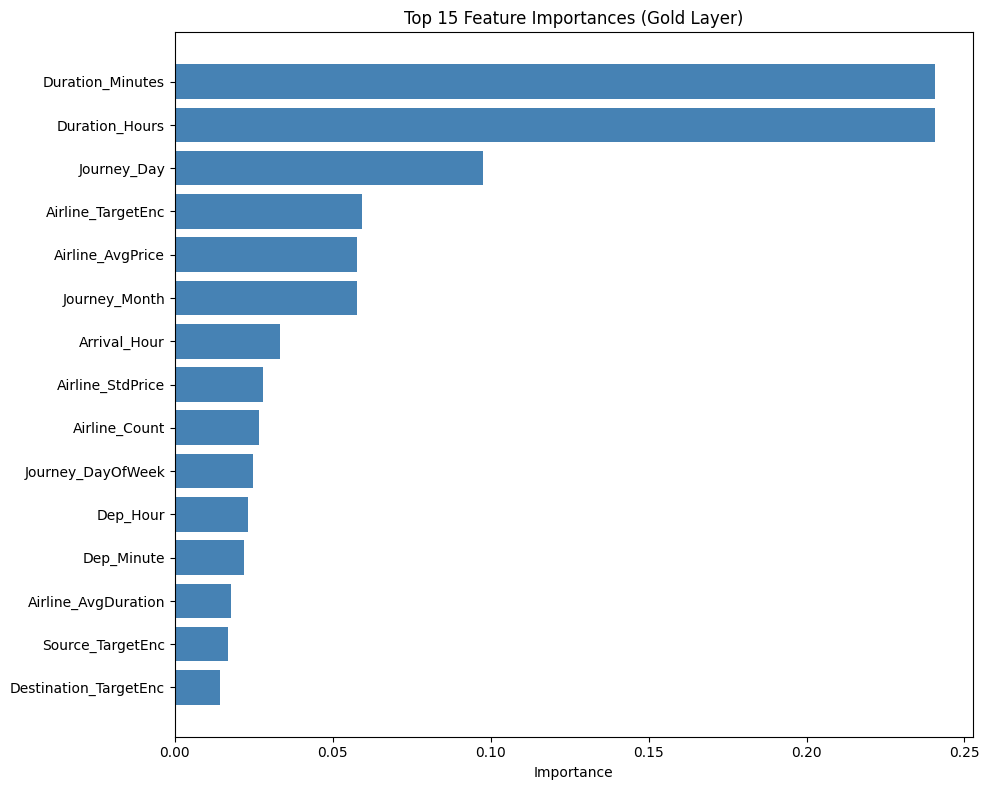

In [13]:
# Feature importance from Gold layer
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Gold Layer)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Pipeline Metrics & Monitoring

In [14]:
# Pipeline metrics summary
pipeline_metrics = {
    'pipeline_run_id': df_gold['_batch_id'].iloc[0],
    'timestamp': datetime.now().isoformat(),
    'layers': {
        'bronze': {
            'records': len(df_bronze),
            'columns': len(df_bronze.columns),
            'file': str(bronze_file.name)
        },
        'silver': {
            'records': len(df_silver),
            'columns': len(df_silver.columns),
            'valid_records': int(df_silver['_is_valid_duration'].sum()),
            'file': str(silver_file.name)
        },
        'gold': {
            'records': len(df_gold),
            'features': len(feature_cols),
            'file': str(gold_file.name)
        }
    },
    'model_metrics': {
        'rmse': round(rmse, 2),
        'mae': round(mae, 2),
        'r2': round(r2, 4)
    }
}

print("Pipeline Metrics Summary:")
print(json.dumps(pipeline_metrics, indent=2))

Pipeline Metrics Summary:
{
  "pipeline_run_id": "20260210101237",
  "timestamp": "2026-02-10T10:12:49.521641",
  "layers": {
    "bronze": {
      "records": 10683,
      "columns": 16,
      "file": "flights_bronze_20260210101237.parquet"
    },
    "silver": {
      "records": 10683,
      "columns": 32,
      "valid_records": 10682,
      "file": "flights_silver_20260210101237.parquet"
    },
    "gold": {
      "records": 10682,
      "features": 21,
      "file": "flights_gold_20260210101237.parquet"
    }
  },
  "model_metrics": {
    "rmse": 1511.36,
    "mae": 968.47,
    "r2": 0.8504
  }
}


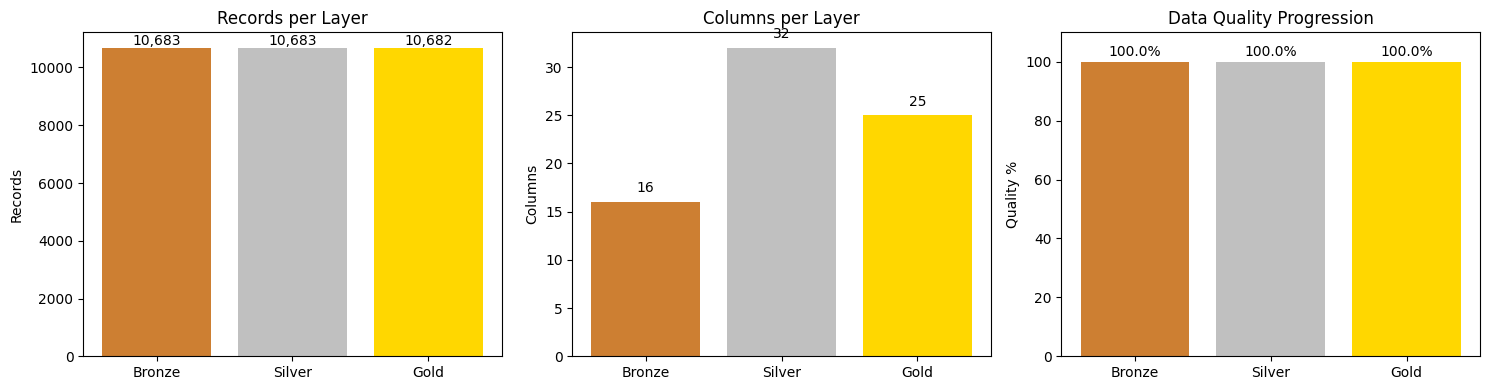

In [15]:
# Visualize pipeline flow
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Records per layer
layers = ['Bronze', 'Silver', 'Gold']
records = [len(df_bronze), len(df_silver), len(df_gold)]
colors = ['#CD7F32', '#C0C0C0', '#FFD700']

axes[0].bar(layers, records, color=colors)
axes[0].set_ylabel('Records')
axes[0].set_title('Records per Layer')
for i, v in enumerate(records):
    axes[0].text(i, v + 100, f'{v:,}', ha='center')

# Columns per layer
columns = [len(df_bronze.columns), len(df_silver.columns), len(df_gold.columns)]
axes[1].bar(layers, columns, color=colors)
axes[1].set_ylabel('Columns')
axes[1].set_title('Columns per Layer')
for i, v in enumerate(columns):
    axes[1].text(i, v + 1, str(v), ha='center')

# Data quality progression
quality = [
    100,  # Bronze: raw
    df_silver['_is_valid_duration'].mean() * 100,  # Silver: filtered
    100  # Gold: all valid by definition
]
axes[2].bar(layers, quality, color=colors)
axes[2].set_ylabel('Quality %')
axes[2].set_title('Data Quality Progression')
axes[2].set_ylim(0, 110)
for i, v in enumerate(quality):
    axes[2].text(i, v + 2, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

In [16]:
# Save pipeline metrics
metrics_file = config.DATA_ROOT / "pipeline_metrics.json"
with open(metrics_file, 'w') as f:
    json.dump(pipeline_metrics, f, indent=2)

print(f"✓ Pipeline metrics saved to {metrics_file}")

✓ Pipeline metrics saved to /Users/proxim/projects/Flight-Airfare-Prediction-on-Azure-with-WebUI/data/pipeline_metrics.json


## Summary

### Medallion Architecture Implemented:

| Layer | Purpose | Records | Columns |
|-------|---------|---------|--------|
| **Bronze** | Raw ingestion + metadata | Raw count | Original + 4 metadata |
| **Silver** | Parsed, cleaned, validated | Filtered | + Temporal, Duration features |
| **Gold** | ML-ready features | Quality filtered | Feature engineered |

### Key Transformations:
- **Bronze → Silver**: Date parsing, time extraction, duration calculation, quality flags
- **Silver → Gold**: Target encoding, route features, airline statistics, feature selection

### Production Considerations:
1. Store each layer in separate partitioned tables/files
2. Track lineage via batch_id across layers
3. Implement incremental processing for new data
4. Add data quality gates between layers